# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set:
- Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [1]:
import pandas as pd
import numpy as np
import math
import json
# matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data - investigation
### portfolio.json
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**Questions specific to portfolio:**
1. What kind of offers exist?
   - *'bogo', 'informational', 'discount'*
2. Is the difficulty of an offer always the same?#
   - *{'bogo': [10, 5], 'discount': [20, 7, 10], 'informational': [0]}*
3. Is the duration of an offer always the same?
   - *{'bogo': [7, 5], 'discount': [10, 7], 'informational': [4, 3]}*
4. What is the value range of the rewards and how do they correlate to difficulty?
   - *{'bogo': [10, 5], 'discount': [5, 3, 2], 'informational': [0]}*
   - *difficulty vs. reward is 1:1 relationship for each offer_type category*
5. Concerning data cleaning - any NaNs contained?
    - data seems to be okay
6. Which channels are used for publishing the offers? -> is there a one that has a higher success-rate? For easier handling of the channels split them into columns with boolean values


difficulty:  {'bogo': [10, 5], 'discount': [20, 7, 10], 'informational': [0]}
duration:  {'bogo': [7, 5], 'discount': [10, 7], 'informational': [4, 3]}
reward:  {'bogo': [10, 5], 'discount': [5, 3, 2], 'informational': [0]}

Null values:
 reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Na values:
 reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

#ids:  10
#rows: 10


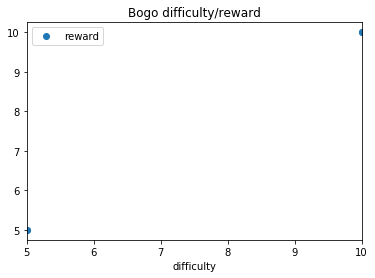

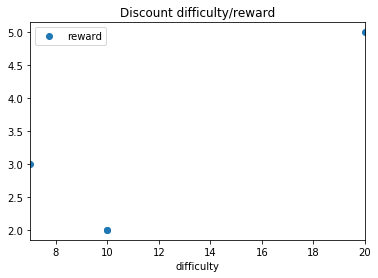

In [3]:
print('difficulty: ', portfolio.groupby(['offer_type'])['difficulty'].unique().apply(list).to_dict()) #1,2
print('duration: ', portfolio.groupby(['offer_type'])['duration'].unique().apply(list).to_dict()) #3 
print('reward: ', portfolio.groupby(['offer_type'])['reward'].unique().apply(list).to_dict()) #4

# checking data concistency
portfolio.loc[portfolio['offer_type'] == 'bogo'].plot(x='difficulty', y='reward', style='o', title='Bogo difficulty/reward')
portfolio.loc[portfolio['offer_type'] == 'discount'].plot(x='difficulty', y='reward', style='o', title='Discount difficulty/reward')

# checking NaNs
print('\nNull values:\n', portfolio.isnull().sum())
print('\nNa values:\n', portfolio.isna().sum())

# checking ids are unique
print('\n#ids: ', portfolio['id'].unique().size)
print('#rows:', portfolio.shape[0])

In [4]:
# dividing array of channels into separate columns
portfolio['email'] = portfolio['channels'].apply(lambda x: 'email' in x)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 'mobile' in x)
portfolio['web'] = portfolio['channels'].apply(lambda x: 'web' in x)
portfolio['social'] = portfolio['channels'].apply(lambda x: 'social' in x)
portfolio['duration'] = portfolio['duration']*24
portfolio = portfolio.drop(['channels'], axis=1)

In [5]:
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,web,social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,True,True,False,True
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,True,True,True,False
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True,False
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,True,False
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,True,True,True,True
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,True,True,True,True
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,True,True,False,True
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,True,True,True,True
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,True,True,True,False


**Conclusions/Actions**
- What is the influence of the duration - are longer or shorter offers better? Especially depending on the channel - emails and web might have a longer time span until they are first noticed by the customers.
- Check which offer-type have the biggest impact

### profile.json
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**Questions specific to profile**
1. How much people have "gender" None? 
2. How much people have an age that is unrealistic high? 
   - there seem to be some 2185 people with age of 2175 -> be careful with those when using age as potential feature!
3. What's the average income and for how many people do we have this data?
   - there are 2175 profiles where we have no income information available
   

age
18       70
19      135
20      135
21      140
22      131
       ... 
98        5
99        5
100      12
101       5
118    2175
Name: age, Length: 85, dtype: int64

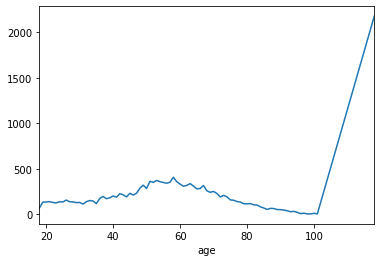

In [7]:
# age distribution
profile.groupby(['age'])['age'].count().plot()
profile.groupby(['age'])['age'].count()

Income that is nan:  2175


income
30000.0      88
31000.0     223
32000.0     216
33000.0     213
34000.0     199
           ... 
116000.0     46
117000.0     32
118000.0     58
119000.0     54
120000.0     13
Name: income, Length: 91, dtype: int64

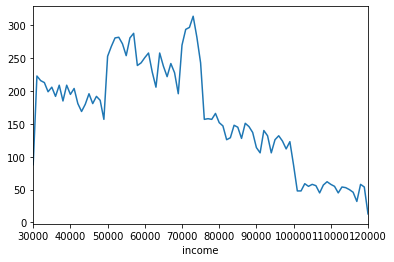

In [8]:
# income 
print('Income that is nan: ', profile['income'].isnull().sum())
profile.groupby(['income'])['income'].count().plot()
profile.groupby(['income'])['income'].count()

In [9]:
# ids
print(profile['id'].unique().size)
print(profile.shape)
# => ids are fine

17000
(17000, 5)


### transcript.json
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [10]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


**Questions on transcript**
1. What kind of events are possible?
2. Who has received the most offers?

**Tasks**
1. Value columns needs to be cleaned in order to join tables together
2. Value column for transaction needs to be separated in order to clean up data


In [11]:
# check event distribution
transcript.groupby(['event'])['event'].count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: event, dtype: int64

In [12]:
# check time entry values
transcript.groupby(['time'])['time'].count()

time
0      15561
6       2506
12      2215
18      2015
24      1921
       ...  
690     1260
696     1326
702     1115
708     1048
714     1130
Name: time, Length: 120, dtype: int64

In [13]:
# create people ranking
transcript.groupby(['person'])['person'].count().sort_values(ascending=False)

person
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
                                    ..
22617705eec442e0b7b43e5c5f56fb17     2
df9fc9a86ca84ef5aedde8925d5838ba     2
3a4e53046c544134bb1e7782248631d1     2
e63e42480aae4ede9f07cac49c8c3f78     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

In [14]:
# data cleaning
transcript[transcript['event']=='transaction']

def determine_amount(dict_entry): 
    if 'amount' in dict_entry:
        return dict_entry['amount']
    else:
        return 0
def determine_portfolio_id(dict_entry):
    if 'offer id' in dict_entry:
        return dict_entry['offer id']
    elif 'offer_id' in dict_entry:
        return dict_entry['offer_id']
    else:
        return None

transcript['amount'] = transcript['value'].apply(lambda x: determine_amount(x))
transcript['portfolio_id'] = transcript['value'].apply(lambda x: determine_portfolio_id(x))
transcript['profile_id'] = transcript["person"]
transcript_new = transcript.drop(['person', 'value'], axis=1)

In [33]:
# join data frames together - prepartion:
profile = profile.rename(columns={"id": "profile_id"})
portfolio = portfolio.rename(columns={"id": "portfolio_id"})

# use inner join between transcript_new and profile to get rid of all transcripts where we have no user data
transcript_user = pd.merge(transcript_new, profile, how='inner', on='profile_id')

# use left join to add offer information -> needed cause transaction type has no id
df = pd.merge(transcript_user, portfolio, how='left', on='portfolio_id')

## check result for an example user
df[df['profile_id']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,time,amount,portfolio_id,profile_id,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,web,social
0,offer received,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,5.0,5.0,168.0,bogo,True,True,True,False
1,offer viewed,6,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,5.0,5.0,168.0,bogo,True,True,True,False
2,transaction,132,19.89,None,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,132,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,5.0,5.0,168.0,bogo,True,True,True,False
4,transaction,144,17.78,None,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,offer received,168,0.00,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,0.0,0.0,72.0,informational,True,True,False,True
6,offer viewed,216,0.00,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,0.0,0.0,72.0,informational,True,True,False,True
7,transaction,222,19.67,None,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,transaction,240,29.72,None,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,transaction,378,23.93,None,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


event
offer completed    33579
offer received     76277
offer viewed       57725
Name: event, dtype: int64
event
offer completed    30159
offer received     68609
offer viewed       55062
Name: event, dtype: int64
event
offer completed    29891
offer received     61001
offer viewed       44322
Name: event, dtype: int64
event
offer completed    21788
offer received     45683
offer viewed       42629
Name: event, dtype: int64


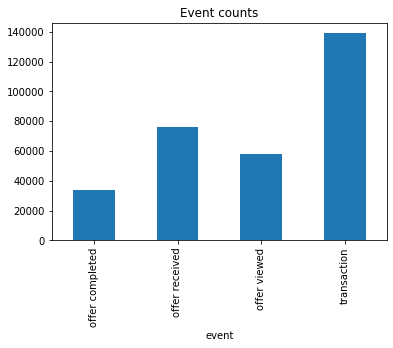

In [17]:
print(df.query("email == 1").groupby(['event'])["event"].count())
print(df.query("mobile == 1").groupby(['event'])["event"].count())
print(df.query("web == 1").groupby(['event'])["event"].count())
print(df.query("social == 1").groupby(['event'])["event"].count())

df.groupby(['event'])["event"].count().plot(kind="bar", title="Event counts")

Completed offers for transactions are at the same point in time as the transaction. All transactions that do not have an offer completed at the same time (per user) are normal puying actions not triggered by bogo or discount. We are not directly able to judge the influence of infomercials to the transactions.

In [76]:
df["transaction_used"] = False

# copy dataframe
df2 = df.copy()

# Rename column names of second dataframe 
df2 = df2.add_prefix("offer__")
# Rename join columns
df2 = df2.rename(columns={"offer__profile_id": "profile_id", "offer__time": "time"})
df2["offer__transaction_used"] = True

# Merge the dataframes into another dataframe based on profile and time
df3 = pd.merge(df, df2, how='outer', on=['profile_id', 'time'])

# determine if transaction has a complete offer and restrict data frame columns
transactions_with_completed_offer = df3.loc[(df3.event == 'transaction') & (df3.offer__event == 'offer completed')]
transactions_with_completed_offer = transactions_with_completed_offer[{'event','time', 'profile_id', 'offer__transaction_used','offer__event','offer__offer_type', 'offer__portfolio_id', 'offer__email', 'offer__mobile', 'offer__web', 'offer__social', 'offer__difficulty'}]
transactions_with_completed_offer.drop_duplicates(subset=['event', 'profile_id', 'time'], inplace=True)

# merge with initial data frame and remove unneccessary and duplicate columns
transaction_usage = pd.merge(df, transactions_with_completed_offer, how='left', on = ['event', 'profile_id', 'time'])
transaction_usage.drop(columns=['transaction_used'], inplace=True)

print('Sanity-Check: Number of rows after transformation is equal: ', final_result.shape, df.shape) 
transaction_usage



Sanity-Check: Number of rows after transformation is equal:  (306534, 25) (306534, 18)


,event,time,amount,portfolio_id,profile_id,gender,age,became_member_on,income,reward,...,social,offer__transaction_used,offer__social,offer__mobile,offer__difficulty,offer__web,offer__portfolio_id,offer__email,offer__event,offer__offer_type
0,offer received,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,5.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,offer viewed,6,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,5.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,transaction,132,19.89,None,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,NaN,...,NaN,True,False,True,5.0,True,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,offer completed,bogo
3,offer completed,132,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,5.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,transaction,144,17.78,None,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,offer received,576,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,912b9f623b9e4b4eb99b6dc919f09a93,None,118,20170926,NaN,10.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,offer viewed,594,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,912b9f623b9e4b4eb99b6dc919f09a93,None,118,20170926,NaN,10.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,offer received,576,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,3045af4e98794a04a5542d3eac939b1f,F,58,20161020,78000.0,10.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,offer viewed,576,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,3045af4e98794a04a5542d3eac939b1f,F,58,20161020,78000.0,10.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check what is the acutal amount of money people spent with and without transaction and what is the reduction.

In [84]:
transaction_usage['net_spent'] = 0
transaction_usage['net_spent'] = transaction_usage['amount'] - transaction_usage['offer__difficulty']
transaction_usage['offer__transaction_used'] = transaction_usage['offer__transaction_used'].astype(str)

transaction_usage
#transactions_only = transaction_usage[transaction_usage['event'] == 'transaction']
#transactions_only.groupby(['offer__transaction_used'])["net_spent"].sum()

,event,time,amount,portfolio_id,profile_id,gender,age,became_member_on,income,reward,...,offer__transaction_used,offer__social,offer__mobile,offer__difficulty,offer__web,offer__portfolio_id,offer__email,offer__event,offer__offer_type,net_spent
0,offer received,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,5.0,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,offer viewed,6,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,5.0,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,transaction,132,19.89,None,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,NaN,...,True,False,True,5.0,True,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,offer completed,bogo,14.89
3,offer completed,132,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,5.0,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,transaction,144,17.78,None,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,NaN,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,offer received,576,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,912b9f623b9e4b4eb99b6dc919f09a93,None,118,20170926,NaN,10.0,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,offer viewed,594,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,912b9f623b9e4b4eb99b6dc919f09a93,None,118,20170926,NaN,10.0,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,offer received,576,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,3045af4e98794a04a5542d3eac939b1f,F,58,20161020,78000.0,10.0,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,offer viewed,576,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,3045af4e98794a04a5542d3eac939b1f,F,58,20161020,78000.0,10.0,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
